In [73]:
import torch
import os
import numpy as np
from PIL import Image
import pandas as pd
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, dataset
import torchtext
from torch.nn.functional import one_hot
import torch.optim as optim

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [12, 30]
#plt.rcParams['figure.dpi'] = 100



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cpu


In [74]:
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, dir, length,num,transform=None):
        self.transform = transform
        self.image_dir = os.path.join(dir,"Images")
        self.df = pd.read_csv(os.path.join(dir,"captions.txt"))

        self.length = length

        self.tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
        self.vocab = torchtext.vocab.build_vocab_from_iterator(
            self.tokenizer(caption) for caption in self.df["caption"][0:num]
        )
        self.vocab.append_token("<start>")
        self.vocab.append_token("<end>")
        self.vocab.append_token("<pad>")
        print(self.vocab.get_stoi())

        #Finds incdicies of <start>, <end>, <pad>
        self.special_indices = self.vocab.lookup_indices(["<start>","<end>","<pad>"])
        print(self.special_indices)

        self.df2 = pd.DataFrame(columns=['image','caption','length'])

        for i, (image, caption) in enumerate(zip(self.df['image'],self.df['caption'])):
            if i%1000==0:
                print(i)
            tokens = self.tokenizer(caption)
            tokens[:0] = ["<start>"]
            tokens.append("<end>")
            if len(tokens)>length:
                continue
            length2 = len(tokens)
            while len(tokens)<length:
                tokens.append("<pad>")

            tokens_num = torch.tensor([self.vocab[token] for token in tokens])
            self.df2.loc[-1] = [image,tokens_num,length2]  # adding a row
            self.df2.index = self.df2.index + 1  # shifting index
            self.df2 = self.df2.sort_index()  # sorting by index

            if (i==num-1):
                break



    def __getitem__(self,i):
        caption = self.df2["caption"][i]
        image_path = os.path.join(self.image_dir,self.df2["image"][i])
        image = transforms.ToTensor()(Image.open(image_path))
        if self.transform!=None:
            image = self.transform(image)
        return (image,caption)

    def __len__(self):
        return len(self.df2)

In [75]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [76]:
ds = CaptionDataset("archive",20,5000,transform=preprocess)
#ds,awd = torch.utils.data.random_split(ds, [int(len(ds)*0.1),len(ds)-int(len(ds)*0.1)])
#vocab_builder = DataLoader(ds,batch_size=1)
#vocab_it = iter(vocab_builder)

#tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
#vocab = torchtext.vocab.build_vocab_from_iterator(
#    tokenizer(caption[1][0]) for caption in vocab_it
#)train_size = int(0.8 * len(full_dataset))
train_size = int(len(ds)*0.8)
val_size = int(len(ds)*0.1)
test_size = len(ds)-train_size-val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, val_size , test_size])
dl_train = DataLoader(ds,batch_size=64,shuffle=True)
dl_val = DataLoader(ds,batch_size=8,shuffle=True)
dl_test = DataLoader(ds,batch_size=1,shuffle=True)

{'green': 50, 'pours': 2792, 'track': 374, 'the': 3, 'meanders': 2603, 'face': 100, 'workers': 1083, 'doll': 1151, 'garbage': 1175, 'winter': 460, 'seems': 2918, 'her': 57, 'outdoors': 228, 'small': 46, 'running': 37, 'swimmers': 1734, 'around': 117, 'bald': 636, 'a': 0, 'gentleman': 1488, 'turbulent': 3175, 'hose': 553, 'group': 69, 'collars': 2081, 'ladder': 987, 'wooded': 378, 'apart': 1841, 'leaves': 266, 'yellow': 63, 'swing': 147, 'bottle': 1375, 'after': 269, 'ribbon': 1265, 'with': 8, 'high-fives': 1518, 'door': 466, 'barbed': 1357, 'seated': 754, 'dog': 7, 'squatting': 1295, 'usual': 3203, 'open': 245, 'barriers': 1107, '.': 1, 'band': 586, 'white': 16, 'an': 28, 'curly': 800, 'helping': 720, 'and': 6, 'traffic': 400, 'outfit': 246, 'soccer': 163, 'in': 2, 'photos': 2750, 'stands': 62, 'tethered': 1747, 'whilst': 323, 'cavern': 2035, 'water': 18, 'raises': 1637, 'presses': 1249, 'crashing': 2130, 'girls': 73, 'trails': 3148, 'charm': 2041, 'on': 4, 'playing': 39, 'punching': 2

In [77]:
print(ds.df2["caption"])
print(ds.df2["length"])
print(len(ds.vocab))

0       [tensor(3286), tensor(0), tensor(63), tensor(7...
1       [tensor(3286), tensor(0), tensor(58), tensor(2...
2       [tensor(3286), tensor(0), tensor(25), tensor(3...
3       [tensor(3286), tensor(0), tensor(25), tensor(7...
4       [tensor(3286), tensor(3), tensor(9), tensor(32...
                              ...                        
4668    [tensor(3286), tensor(0), tensor(29), tensor(1...
4669    [tensor(3286), tensor(0), tensor(29), tensor(1...
4670    [tensor(3286), tensor(0), tensor(29), tensor(1...
4671    [tensor(3286), tensor(0), tensor(13), tensor(3...
4672    [tensor(3286), tensor(0), tensor(35), tensor(2...
Name: caption, Length: 4673, dtype: object
0       19
1       20
2       14
3       11
4       18
        ..
4668    15
4669    12
4670    11
4671    10
4672    20
Name: length, Length: 4673, dtype: int64
3289


In [78]:
import math
x = [0]*len(ds.vocab)
print(x)
for caption in ds.df2['caption']:
  for i in caption:
    x[i.item()] += 1

print(x)
m = max(x)
weights = []
for i,e in enumerate(x):
  try:
    weights.append(m/(100*e))
  except:
    weights.append(m/100)
print(weights)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [79]:
from torchsummary import summary

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(self.resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.dem_red1 = nn.Conv2d(2048, 1024, kernel_size=1, padding=0)
        self.dem_red2 = nn.Conv2d(1024, 512, kernel_size=1, padding=0)
        self.fc1 = nn.Linear(512*7*7,1000)
        self.act = nn.ReLU()
        #self.fc2 = nn.Linear(1000,100)

    def forward(self,x):
        x = self.resnet(x)
        x = self.act(x)
        x = self.dem_red1(x)
        x = self.act(x)
        x = self.dem_red2(x)
        x = self.act(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc1(x)
        #x = self.act(x)
        #x = self.fc2(x)
        return x

model = Encoder()

summary(model.to(device), (3, 224, 224))


C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Anton\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [80]:
class Decoder(nn.Module):
    #LSTM
    def __init__(self, embedding_dim, encoded_dim, vocab_size, output_length):
        super().__init__()
        self.hidden_dim = encoded_dim
        self.vocab_size = vocab_size
        self.output_length = output_length

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTMCell(embedding_dim, encoded_dim)
        self.linear = nn.Linear(encoded_dim, vocab_size)

        self.drop = nn.Dropout(0.2)

        self.positional_emb = nn.Embedding(encoded_dim, embedding_dim)

    def forward(self, start_word, h0, label=None):
        word = self.embeddings(start_word)
        hx = h0
        cx = h0
        outputs = torch.clone(one_hot(start_word,self.vocab_size))
        word = torch.squeeze(word,1)
        while outputs.size(1)<self.output_length:
            if label!=None:
                #print(label.shape)
                #print(label[:,outputs.size(1)-1])
                word = self.embeddings(label[:,outputs.size(1)])
            word = self.drop(word + h0)
            hx, cx = self.lstm(word, (hx, cx))
            word = self.linear(self.drop(hx))
            outputs = torch.cat((outputs,torch.unsqueeze(word,dim=1)),dim=1)
            word = self.embeddings(torch.argmax(word,dim=1))
        return outputs

#d = Decoder(10,10,15)
#start = (torch.unsqueeze(torch.ones(13),1)*14).to(torch.int64)
#print(start)
#print(start.shape)
#enc = torch.rand(13,10)
#print(enc)
#print(enc.shape)
#o = d(start,enc)
#print(o)
#print(o.shape)
#lab = torch.randint(0,15,(13,3))
#lab = one_hot(lab).to(torch.float)
#print(lab.shape)
#criterion = nn.CrossEntropyLoss()
#loss = criterion(o,lab)
#print(loss)
#loss.backward()

In [81]:
def train(encoder, decoder, optimizer, criterion, test_loader, val_loader, epochs, start_token_idx):
    summ = [0,0,0,0,0,0,0,0,0,0,0,0]
    it = iter(val_loader)
    for epoch in range(epochs):
        print("Processing Epoch:",epoch)
        for batch_nr, (image, label) in enumerate(test_loader):
            print("Starting batch:", batch_nr)
            image = image.to(device)
            label = label.to(device)

            # Forward pass
            img = encoder(image)

            start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*start_token_idx).to(torch.int64).to(device)

            pred = decoder(start_tokens, img, label)
            label = one_hot(label).to(torch.float)

            #Backwards pass
            optimizer.zero_grad()
            pred = pred.flatten(0,1)
            label = label.flatten(0,1)
            loss = criterion(pred,label)
            print(loss.item()*1000)
            summ.append(loss.item())
            print("Running avg:", sum(summ[-10:])*100)
            loss.backward()
            optimizer.step()

            if batch_nr%5==0:
              try:
                img, label = next(it)
              except:
                it = iter(val_loader)
                img, label = next(it)

              plt.imshow(img[0].permute(1, 2, 0))
              plt.show()
              img = encoder(img.to(device))
              start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*ds.special_indices[0]).to(torch.int64).to(device)
              pred = decoder(start_tokens, img)
              c = torch.argmax(pred,dim=2)
              print(ds.vocab.lookup_tokens(label[0].tolist()))
              print(ds.vocab.lookup_tokens(c[0].tolist()))
              label = one_hot(label).to(torch.float)
              pred = pred.flatten(0,1)
              label = label.flatten(0,1)
              loss = criterion(pred,label)
              print("val loss:",loss.item())


In [82]:
ds.vocab.get_itos()

['a',
 '.',
 'in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'boy',
 'girl',
 'to',
 'black',
 'white',
 'woman',
 'water',
 'at',
 'wearing',
 'are',
 ',',
 'young',
 'his',
 'brown',
 'people',
 'red',
 'an',
 'little',
 'blue',
 'standing',
 'through',
 'down',
 'dogs',
 'child',
 'while',
 'running',
 'shirt',
 'playing',
 'up',
 'grass',
 'three',
 'front',
 'person',
 'sitting',
 'small',
 'beach',
 'into',
 'walking',
 'green',
 'jumping',
 'field',
 'children',
 'ball',
 'rock',
 'by',
 'her',
 'large',
 'near',
 'holding',
 'one',
 'stands',
 'yellow',
 'over',
 'from',
 'mouth',
 'next',
 'out',
 'group',
 'climbing',
 'its',
 'snow',
 'girls',
 'another',
 'street',
 'pink',
 'for',
 'men',
 'jumps',
 'pool',
 'air',
 'looking',
 'runs',
 'other',
 'toy',
 'riding',
 'sits',
 'jacket',
 'as',
 'hat',
 'mountain',
 'camera',
 'walks',
 'off',
 'boys',
 'some',
 'wall',
 'outside',
 'shorts',
 'face',
 'their',
 'top',
 'play',
 'bike',
 'catch',
 

Processing Epoch: 0
Starting batch: 0
99682.17468261719
Running avg: 9968.217468261719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


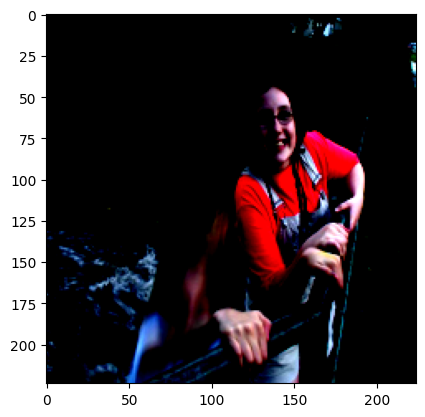

['<start>', 'children', 'playing', 'in', 'stopped', 'motion', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'preparing', 'hilly', 'pen', 'ravine', 'tussling', 'fighting', 'blitz', 'readying', 'exhibit', 'hood', 'writing', 'sad', 'hall', 'backpacks', 'audience', 'landed', 'landed', 'advertisement', 't-shirt']
val loss: 154.1576690673828
Starting batch: 1
94387.5503540039
Running avg: 19406.97250366211
Starting batch: 2
80344.30694580078
Running avg: 27441.403198242188
Starting batch: 3


KeyboardInterrupt: 

In [83]:
LEARNING_RATE = 0.0001
EPOCHS = 100

encoder = Encoder().to(device)
decoder = Decoder(1000,1000,len(ds.vocab),20).to(device)
#weight=torch.tensor(weigths) weight=torch.tensor(weights.flatten())
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights)).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

train(encoder,decoder,optimizer,criterion,dl_train,dl_val,EPOCHS,ds.special_indices[0])


In [ ]:
it_test = iter(dl_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


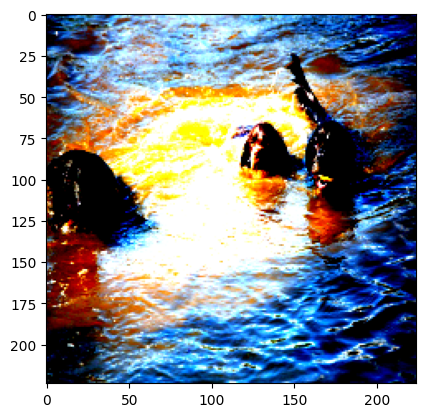

['<start>', 'three', 'dark', 'dogs', 'swimming', 'and', 'one', 'of', 'them', 'has', 'a', 'ball', '.', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'plates', 'blocking', 'hoodie', 'field', 'person', 'kissed', 'violins', 'beret', 'soaking', 'soaking', 'uniforms', 'uniforms', 'skis', 'straps', 'lake', 'sunlight', 'shoes', 'perform', 'firehose']
val loss: 0.01794450543820858


In [ ]:
img, label = next(it_test)

plt.imshow(img[0].permute(1, 2, 0))
plt.show()
img = encoder(img.to(device))
start_tokens = (torch.unsqueeze(torch.ones(label.size(0)),1)*ds.special_indices[0]).to(torch.int64).to(device)
pred = decoder(start_tokens, img)
c = torch.argmax(pred,dim=2)
print(ds.vocab.lookup_tokens(label[0].tolist()))
print(ds.vocab.lookup_tokens(c[0].tolist()))
label = one_hot(label).to(torch.float)
loss = criterion(pred,label)
print("val loss:",loss.item())